<a href="https://colab.research.google.com/github/martharegina/machinelearning/blob/main/lendingclub_oc_pb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import resample
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [33]:
# Load dataset

object_cols = [
    'annual_inc',
    'dti',
    'fico_range_low',
    'fico_range_high',
    'emp_length',
    'revol_util',
    'total_acc',
    'open_acc',
    'delinq_2yrs',
    'loan_amnt',
    'installment',
    'term',
    'int_rate',
    'purpose',
    'application_type',
    'home_ownership',
    'issue_d'
]

data = pd.read_csv(
    '/content/accepted_2007_to_2018Q4.csv.gz',
    compression='gzip',
    usecols=object_cols,
    low_memory=False)
data.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,issue_d,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,open_acc,revol_util,total_acc,application_type
0,3600.0,36 months,13.99,123.03,10+ years,MORTGAGE,55000.0,Dec-2015,debt_consolidation,5.91,0.0,675.0,679.0,7.0,29.7,13.0,Individual
1,24700.0,36 months,11.99,820.28,10+ years,MORTGAGE,65000.0,Dec-2015,small_business,16.06,1.0,715.0,719.0,22.0,19.2,38.0,Individual
2,20000.0,60 months,10.78,432.66,10+ years,MORTGAGE,63000.0,Dec-2015,home_improvement,10.78,0.0,695.0,699.0,6.0,56.2,18.0,Joint App
3,35000.0,60 months,14.85,829.90,10+ years,MORTGAGE,110000.0,Dec-2015,debt_consolidation,17.06,0.0,785.0,789.0,13.0,11.6,17.0,Individual
4,10400.0,60 months,22.45,289.91,3 years,MORTGAGE,104433.0,Dec-2015,major_purchase,25.37,1.0,695.0,699.0,12.0,64.5,35.0,Individual


In [34]:
# Drop baris yang punya missing values
data = data.dropna(axis=0)
data.shape

(2111997, 17)

In [35]:
# Pilih data di tahun 2018 saja
data['issue_d'] = pd.to_datetime(data['issue_d'])
data = data[data['issue_d'].dt.year == 2018]

/tmp/ipython-input-2363021634.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['issue_d'] = pd.to_datetime(data['issue_d'])


In [36]:
# Ordinal encoding emp_length
emp_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}
data['emp_length'] = data['emp_length'].map(emp_map)

In [37]:
# Binary encoding term
data['term'] = data['term'].map({' 36 months': 0, ' 60 months': 1})

In [91]:
# Behavioral grouping purpose
consumption = [
    'credit_card', 'vacation', 'wedding', 'moving',
    'medical', 'other', 'car'
]

productive = [
    'house', 'home_improvement', 'renewable_energy',
    'debt_consolidation', 'small_business', 'major_purchase'
]

def map_purpose(x):
    if x in consumption:
        return 'consumption'
    elif x in productive:
        return 'productive'

data['purpose_group'] = data['purpose'].apply(map_purpose)

In [39]:
# Binary encoding application_type
data['joint_app'] = (data['application_type'] == 'Joint App').astype(int)
data = data.drop(columns=['application_type'], axis=1)

In [40]:
# Ordinal encoding home_ownership
home_map = {
    'RENT': 0,
    'MORTGAGE': 1,
    'OWN': 2,
    'ANY': 0
}

data['home_ownership'] = data['home_ownership'].map(home_map)

In [41]:
# Tambah kolom loan_to_income and installment_to_income
data['loan_to_income'] = data['loan_amnt'] / data['annual_inc']
data['installment_to_income'] = data['installment'] / data['annual_inc']

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452656 entries, 421097 to 1611876
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   loan_amnt              452656 non-null  float64       
 1   term                   452656 non-null  int64         
 2   int_rate               452656 non-null  float64       
 3   installment            452656 non-null  float64       
 4   emp_length             452656 non-null  int64         
 5   home_ownership         452656 non-null  int64         
 6   annual_inc             452656 non-null  float64       
 7   issue_d                452656 non-null  datetime64[ns]
 8   purpose                452656 non-null  object        
 9   dti                    452656 non-null  float64       
 10  delinq_2yrs            452656 non-null  float64       
 11  fico_range_low         452656 non-null  float64       
 12  fico_range_high        452656 non-null  flo

# Overconfidence

In [43]:
features_oc = [
    'loan_to_income',
    'installment_to_income',
    'dti',
    'fico_range_low',
    'revol_util',
    'emp_length',
    'delinq_2yrs'
]

In [44]:
np.isinf(data[features_oc]).sum()

,0
loan_to_income,1
installment_to_income,1
dti,0
fico_range_low,0
revol_util,0
emp_length,0
delinq_2yrs,0


In [45]:
data[features_oc] = data[features_oc].replace([np.inf, -np.inf], np.nan)

In [46]:
data_oc = data[features_oc].dropna()

In [47]:
X_oc = StandardScaler().fit_transform(data_oc)

In [57]:
# Pertimbangan jumlah cluster
X_sample = resample(X_oc, n_samples=50000, random_state=42)

sil = []
for k in range(2,7):
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000)
    labels = km.fit_predict(X_sample)
    sil.append(silhouette_score(X_sample, labels))

sil

[np.float64(0.23066879440483096),
 np.float64(0.24517169096146693),
 np.float64(0.2454923032154201),
 np.float64(0.2220594340807672),
 np.float64(0.2174725008257129)]

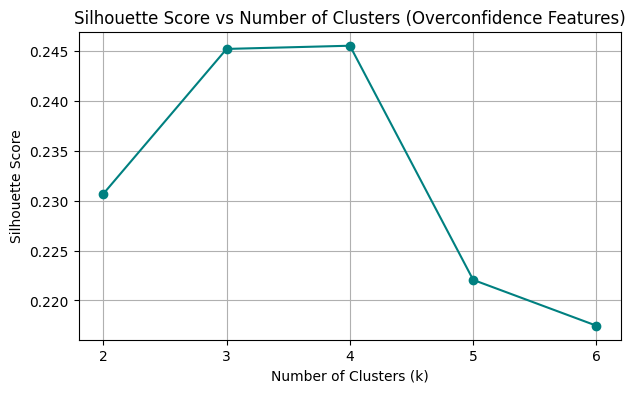

In [150]:
# Plot silhoutte scores

# Jumlah cluster yang diuji
k_values = range(2, 7)

# Silhouette scores dari notebook kamu
sil_scores = [
    0.23066879440483096,
    0.24517169096146693,
    0.2454923032154201,
    0.2220594340807672,
    0.2174725008257129
]

# Plot line chart
plt.figure(figsize=(7,4))
plt.plot(k_values, sil_scores, marker='o', linestyle='-', color='teal')
plt.xticks(k_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters (Overconfidence Features)")
plt.grid(True)
plt.show()

In [84]:
# Clustering k=3
kmeans = KMeans(n_clusters=3, random_state=42)
data_oc['OC_cluster'] = kmeans.fit_predict(X_oc)

In [156]:
# Buat cluster profile
cluster_profile = data_oc.groupby('OC_cluster')[features_oc].mean()
cluster_profile

,loan_to_income,installment_to_income,dti,fico_range_low,revol_util,emp_length,delinq_2yrs
OC_cluster,,,,,,,
0,0.241837,0.007318,18.943412,689.245762,51.315087,2.325430,0.238962
1,0.243044,0.006754,17.133798,750.555001,19.351624,6.114045,0.076123
2,0.264236,0.007900,21.102408,690.090418,55.752518,9.309386,0.346536


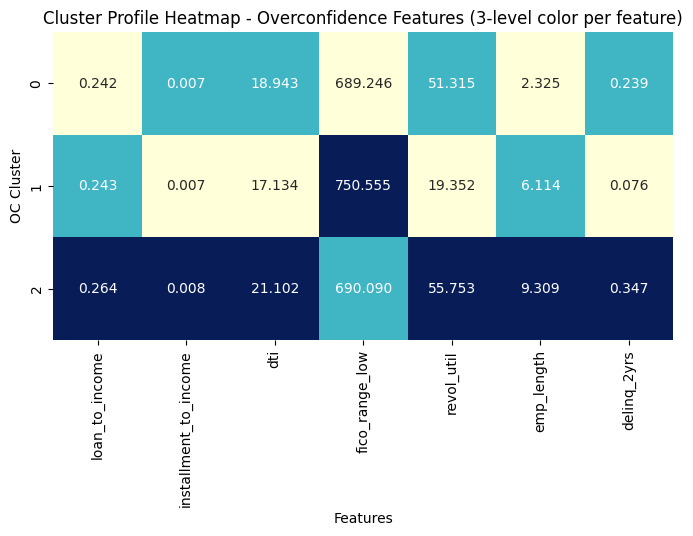

In [160]:
def color_rank(x):
    ranks = x.rank(method='min')  # memberi peringkat cluster per kolom
    # Normalisasi rank ke 0,0.5,1 → 3 warna
    return (ranks - 1) / (len(ranks) - 1)

cluster_profile_norm = cluster_profile.apply(color_rank, axis=0)

plt.figure(figsize=(8,4))
sns.heatmap(cluster_profile_norm, annot=cluster_profile, fmt=".3f", cmap='YlGnBu', cbar=False)
plt.title("Cluster Profile Heatmap - Overconfidence Features (3-level color per feature)")
plt.xlabel("Features")
plt.ylabel("OC Cluster")
plt.show()

In [63]:
data_oc['overconfident'] = (data_oc['OC_cluster'] == 2).astype(int)

In [68]:
from scipy.stats import f_oneway

f_oneway(
    data_oc[data_oc.OC_cluster==0]['delinq_2yrs'],
    data_oc[data_oc.OC_cluster==1]['delinq_2yrs'],
    data_oc[data_oc.OC_cluster==2]['delinq_2yrs']
)

F_onewayResult(statistic=np.float64(4563.13930653073), pvalue=np.float64(0.0))

# Present Bias

In [133]:
features_pb = [
    'term',
    'installment_to_income',
    'int_rate',
    'loan_to_income',
    'delinq_2yrs'
]

In [134]:
np.isinf(data[features_pb]).sum()

,0
term,0
installment_to_income,0
int_rate,0
loan_to_income,0
delinq_2yrs,0


In [135]:
data[features_pb] = data[features_pb].replace([np.inf, -np.inf], np.nan)

In [136]:
pb_cols = features_pb + ['purpose_group']

In [137]:
data_pb = data[pb_cols].dropna()

In [138]:
X_pb = StandardScaler().fit_transform(data_pb[features_pb])

In [139]:
# Pertimbangan jumlah cluster
X_sample = resample(X_pb, n_samples=50000, random_state=42)

sil = []
for k in range(2,7):
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000)
    labels = km.fit_predict(X_sample)
    sil.append(silhouette_score(X_sample, labels))

sil

[np.float64(0.5553044539941017),
 np.float64(0.5377778834493265),
 np.float64(0.5329255776063355),
 np.float64(0.49797730363432413),
 np.float64(0.45513883340661365)]

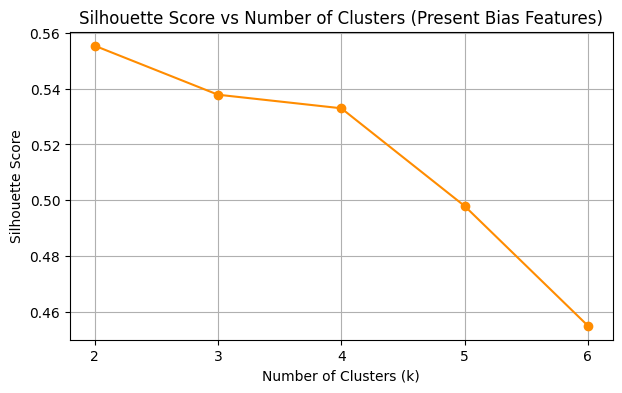

In [151]:
# Jumlah cluster yang diuji
k_values = range(2, 7)

# Silhouette scores dari notebook kamu (Present Bias)
sil_scores_pb = [
    0.5553044539941017,
    0.5377778834493265,
    0.5329255776063355,
    0.49797730363432413,
    0.45513883340661365
]

# Plot line chart
plt.figure(figsize=(7,4))
plt.plot(k_values, sil_scores_pb, marker='o', linestyle='-', color='darkorange')
plt.xticks(k_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters (Present Bias Features)")
plt.grid(True)
plt.show()

In [140]:
# Clustering k=3
kmeans = KMeans(n_clusters=2, random_state=42)
data_pb['PB_cluster'] = kmeans.fit_predict(X_pb)

In [161]:
# Buat cluster profile
cluster_profile = data_pb.groupby('PB_cluster')[features_pb].mean()
cluster_profile

,term,installment_to_income,int_rate,loan_to_income,delinq_2yrs
PB_cluster,,,,,
0,0.998921,0.008753,15.154950,0.352625,0.209908
1,0.000000,0.006751,11.601902,0.204098,0.242942


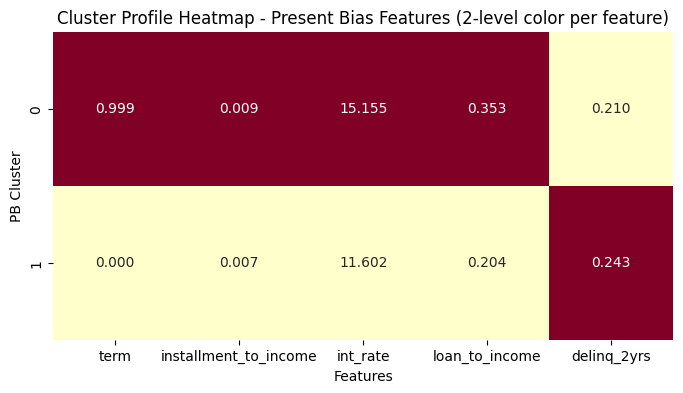

In [162]:
def color_rank_pb(x):
    ranks = x.rank(method='min')  # peringkat cluster per kolom
    return (ranks - 1) / (len(ranks) - 1)  # 0 dan 1 untuk 2 cluster

cluster_profile_pb_norm = cluster_profile_pb.apply(color_rank_pb, axis=0)

plt.figure(figsize=(8,4))
sns.heatmap(cluster_profile_pb_norm, annot=cluster_profile_pb, fmt=".3f", cmap='YlOrRd', cbar=False)
plt.title("Cluster Profile Heatmap - Present Bias Features (2-level color per feature)")
plt.xlabel("Features")
plt.ylabel("PB Cluster")
plt.show()

In [142]:
data_pb['present_biased'] = (data_pb['PB_cluster'] == 0).astype(int)

In [143]:
pd.crosstab(data_pb['PB_cluster'], data_pb['purpose_group'], normalize='index')

purpose_group,consumption,productive
PB_cluster,,
0,0.301804,0.698196
1,0.395829,0.604171


In [120]:
data['purpose_group'].value_counts(normalize=True)

,proportion
purpose_group,
productive,0.633238
consumption,0.366762


In [131]:
# Merge purpose_group dari data
data_pb = data_pb.merge(
    data[['purpose_group']],
    left_on='index',
    right_index=True,
    how='left'
)

In [145]:
# Ambil jumlah terkecil sebagai reference
min_count = data_pb['purpose_group'].value_counts().min()

# Stratified sampling
data_pb_balanced = data_pb.groupby('purpose_group').apply(lambda x: x.sample(min_count, random_state=42))
data_pb_balanced = data_pb_balanced.reset_index(drop=True)

# Cek proporsinya
data_pb_balanced['purpose_group'].value_counts(normalize=True)

/tmp/ipython-input-3556290270.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_pb_balanced = data_pb.groupby('purpose_group').apply(lambda x: x.sample(min_count, random_state=42))


,proportion
purpose_group,
consumption,0.5
productive,0.5


In [146]:
from sklearn.utils import resample

consumption = data_pb[data_pb['purpose_group'] == 'consumption']
productive = data_pb[data_pb['purpose_group'] == 'productive']

# Oversample consumption agar jumlah sama dengan productive
consumption_upsampled = resample(consumption, replace=True, n_samples=len(productive), random_state=42)

# Gabungkan kembali
data_pb_balanced = pd.concat([productive, consumption_upsampled])

In [166]:
ct_balanced = pd.crosstab(data_pb_balanced['PB_cluster'], data_pb_balanced['purpose_group'], normalize='index')
ct_balanced

purpose_group,consumption,productive
PB_cluster,,
0,0.428303,0.571697
1,0.530453,0.469547


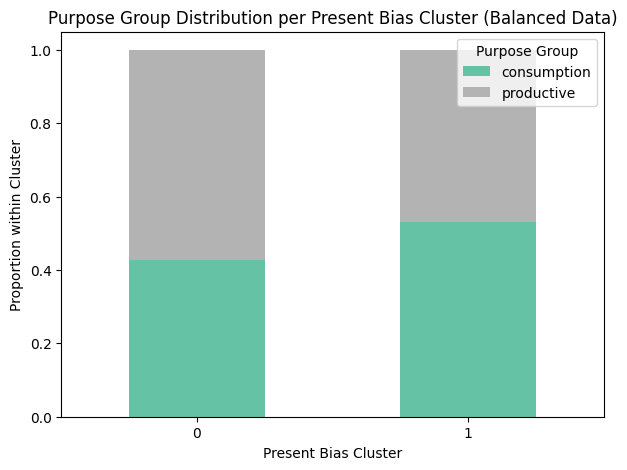

In [167]:
ct_balanced.plot(kind='bar', stacked=True, figsize=(7,5), colormap='Set2')
plt.ylabel("Proportion within Cluster")
plt.xlabel("Present Bias Cluster")
plt.title("Purpose Group Distribution per Present Bias Cluster (Balanced Data)")
plt.legend(title="Purpose Group")
plt.xticks(rotation=0)
plt.show()

In [144]:
from scipy.stats import f_oneway

f_oneway(
    data_pb[data_pb.PB_cluster==0]['delinq_2yrs'],
    data_pb[data_pb.PB_cluster==1]['delinq_2yrs']
)

F_onewayResult(statistic=np.float64(186.64058397651104), pvalue=np.float64(1.754264583403895e-42))